# MBHB Astrometric Calculator
A simple notebook to exercise the MBHB waveform code to compute SNR, SNR vs. time, and resolution vs. time

To run this on Google Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/binaryResolution.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
    
# Import
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')
import constants
import metrics
import concepts
import PhenomWaveform_nonspinning as chirp

### Total SNR
first we compute the total SNR

In [2]:
# define the system
binaryParams = {
    'm1' : 1e6,     # mass of object 1, Solar Masses
    'm2' : 1e6,     # mass of object 2, Solar Masses
    'dkpc' : 6.7e6  # distance to objects, kpc (6.7e6 kpc is z ~ 1)
}

binaryParams['mtot']=(binaryParams['m1']+binaryParams['m2'])*constants.MSun2s
binaryParams['eta']=(binaryParams['m1']*binaryParams['m2'])/((binaryParams['m1']+binaryParams['m2'])**2)
binaryParams['ds']=binaryParams['dkpc']*constants.kpc2s
binaryParams

{'m1': 1000000.0,
 'm2': 1000000.0,
 'dkpc': 6700000.0,
 'mtot': 9.472,
 'eta': 0.25,
 'ds': 6.89611742000524e+17}

In [3]:
# define the concept
model=concepts.LISASciRDv1
model

{'label': 'LISA(SciRDv1)',
 'sqSacc_level': 3e-15,
 'sqSoms_level': 1.5e-11,
 'Lconst': 2500000000.0,
 'Dsep': 0,
 'Rorbit': 1.0,
 'Torbit': 1.0,
 'Nindep': 2}

In [4]:
# frequencies
fmin = 1e-5   # min for plotting and SNR calc
fmax = 1      # max for plotting
fcut = chirp.getFcut(binaryParams['mtot'],binaryParams['eta'])  # max for SNR eval
fplot = np.logspace(np.log10(fmin),np.log10(fmax))
fsnr = np.logspace(np.log10(fmin),np.log10(fcut))


In [5]:
# calculate the SNR
h = chirp.binaryAmp(fsnr,binaryParams['mtot'],binaryParams['eta'],binaryParams['ds'])
S_h_snr = metrics.makeSensitivity(fsnr, model)
snri = 4*np.real(h*np.conjugate(h)/S_h_snr)
snr = np.sqrt(np.sum(np.diff(fsnr)*snri[1:]))
print('SNR = %4.3g' % snr)

SNR = 7.19e+03


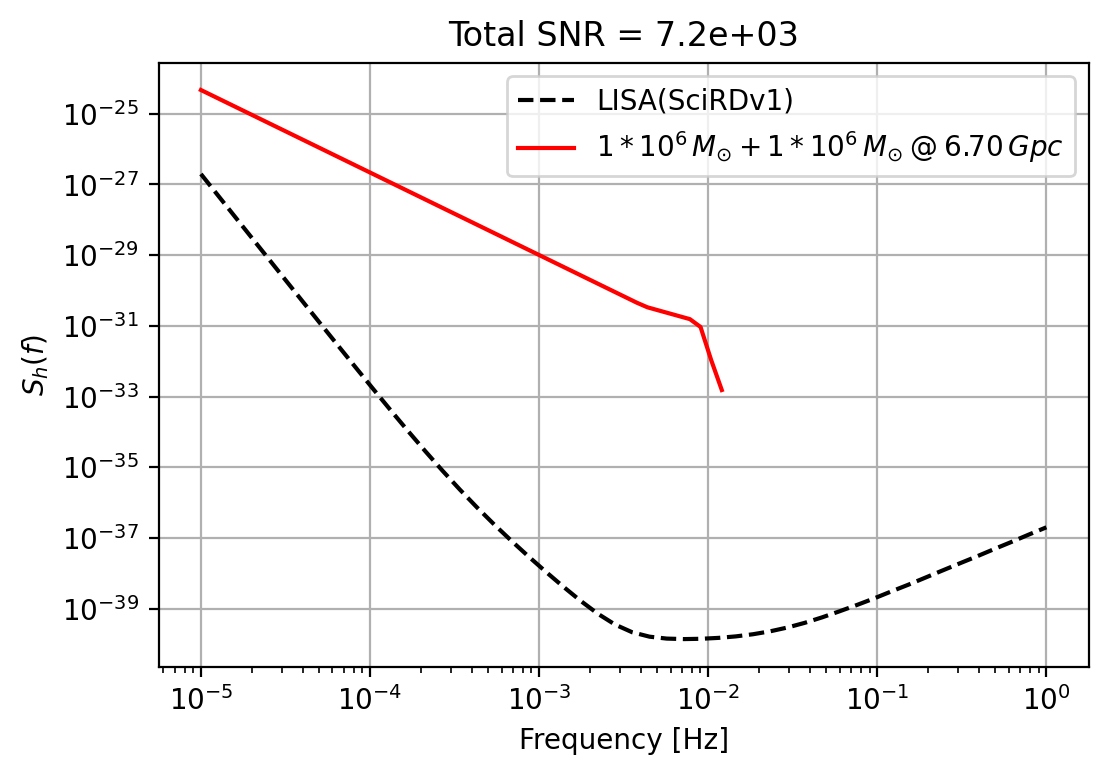

In [6]:
# Make the plot
S_h_plot = metrics.makeSensitivity(fplot,model)
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(fplot,S_h_plot,'none',color='black',linestyle='--',label=model.get('label'))
m1ex = np.floor(np.log10(binaryParams['m1']))
m1fac = binaryParams['m1']/(10**m1ex)
m2ex = np.floor(np.log10(binaryParams['m2']))
m2fac = binaryParams['m2']/(10**m2ex)
sigLabel = r'$%2.0f*10^{%2.0f}\,M_{\odot} + %2.0f*10^{%2.0f}\,M_{\odot}\:@\:%3.2f\,Gpc$' % (m1fac, m1ex, m2fac, m2ex,binaryParams['dkpc']/1e6)
ax.plot(fsnr,np.abs(h)**2,'none',color='red',linestyle='-',label=sigLabel)
plt.title(r'Total SNR = %3.2g' % snr)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S_h(f)$')
plt.legend()
ax.grid(True)

### SNR as a function of time

In [7]:
# set up time vector
Npts = 100
tstart = -constants.year # start time is a year
# stop time is when we get to merger frequency / 3 to avoid PN blow-up
tstop = chirp.tFromF(0.3*chirp.getFmerge(binaryParams['mtot'],binaryParams['eta']),binaryParams['mtot'],binaryParams['eta'])
tvals = -np.flip(np.logspace(np.log10(-tstop),np.log10(-tstart),Npts))

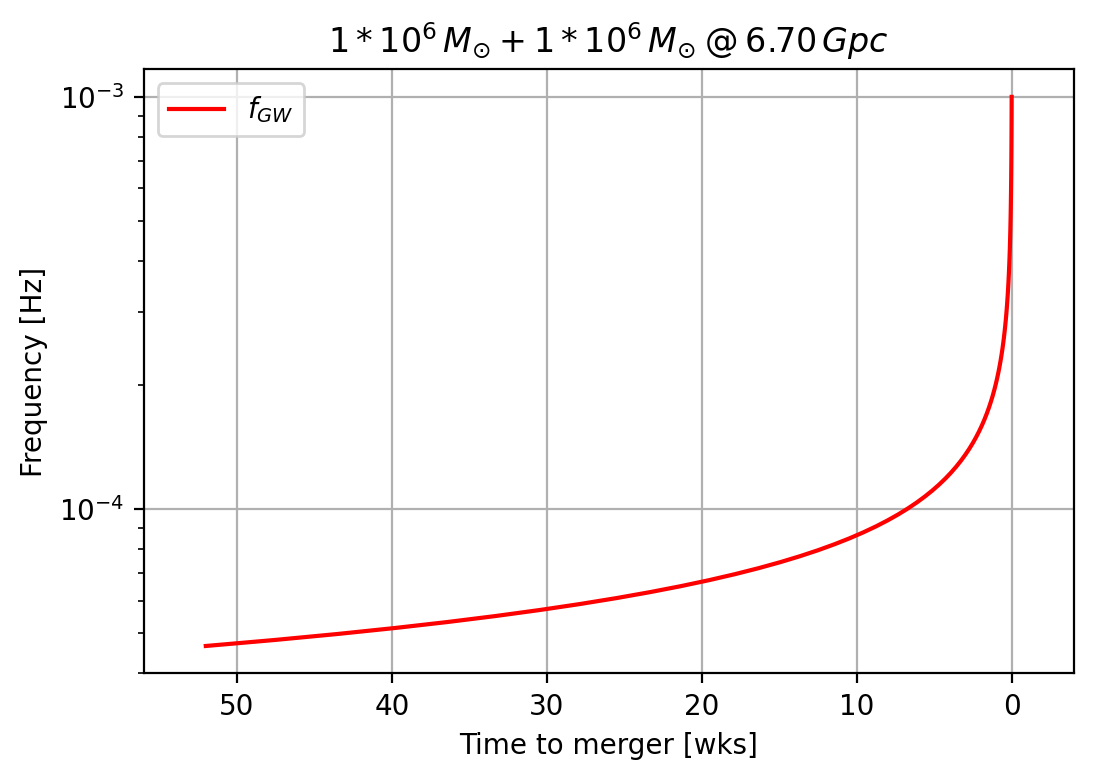

In [8]:
f_of_t = chirp.fFromT(tvals,binaryParams['mtot'],binaryParams['eta'])
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(-tvals*52/constants.year,f_of_t,'none',color='red',linestyle='-',label=r'$f_{GW}$')
plt.title(sigLabel)
plt.xlim([-tstart*52/constants.year+4,-4])
ax.set_xscale('linear')
ax.set_yscale('log')
plt.xlabel('Time to merger [wks]')
plt.ylabel(r'Frequency [Hz]')
plt.legend()
ax.grid(True)

In [9]:
# compute the amplitude as a function of time using the frequency map
h_of_t = chirp.binaryAmp(f_of_t,binaryParams['mtot'],binaryParams['eta'],binaryParams['ds'])
S_h_of_t=metrics.makeSensitivity(f_of_t, model)
snri = 4*np.real(h_of_t*np.conjugate(h_of_t)/S_h_of_t)
snr_of_t = np.sqrt(np.cumsum(np.diff(f_of_t)*snri[1:]))


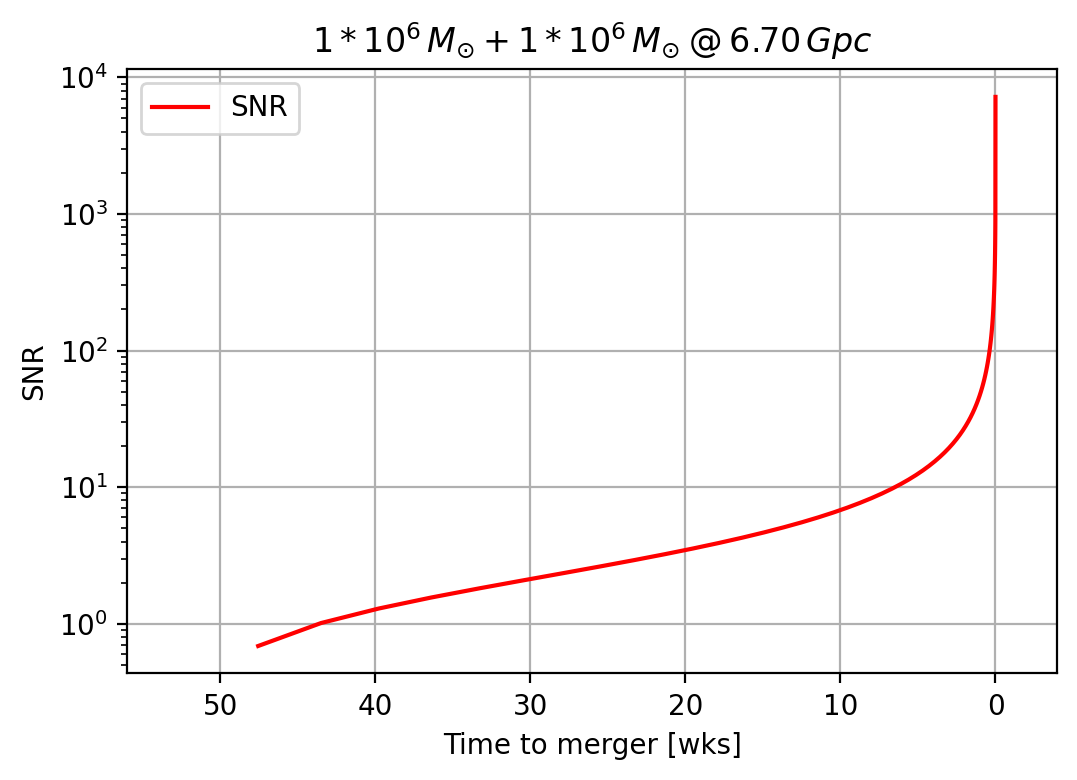

In [10]:
tplot = np.append(tvals[1:],0)
snrplot = np.append(snr_of_t,snr)
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(-tplot*52/constants.year,snrplot,'none',color='red',linestyle='-',label=r'SNR')
plt.title(sigLabel)
plt.xlim([-tstart*52/constants.year+4,-4])
ax.set_xscale('linear')
ax.set_yscale('log')
plt.xlabel('Time to merger [wks]')
plt.ylabel(r'SNR')
plt.legend()
ax.grid(True)
plt.yscale('log')

### Angular resolution as a function of time

/Users/jgbaker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Text(0, 0.5, 'Diffraction limit [rad]')

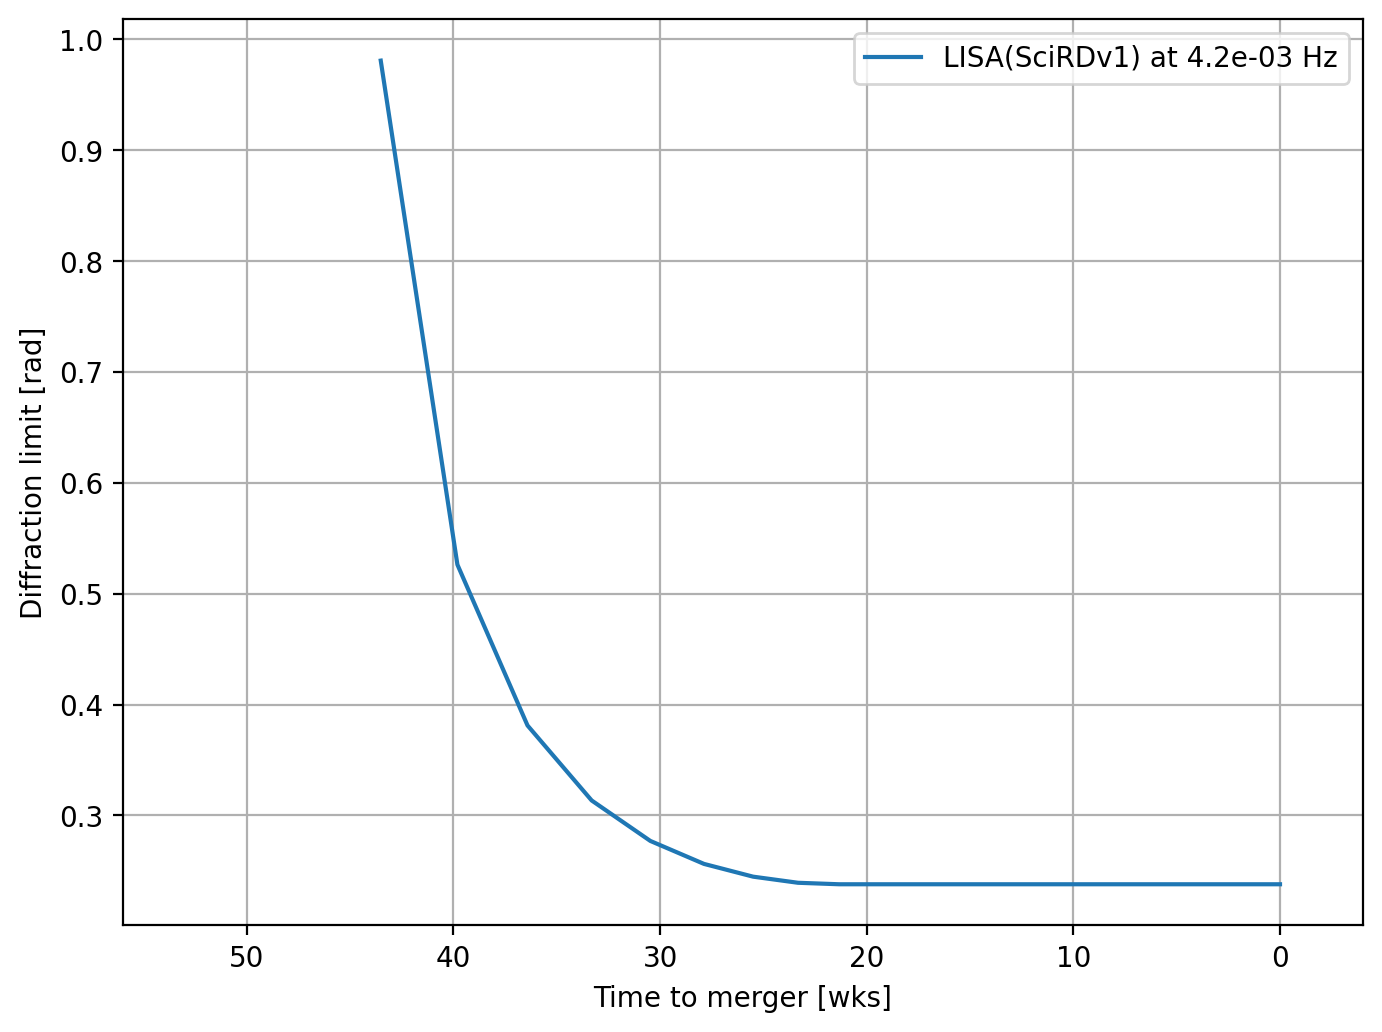

In [11]:
# Estimate diffraction limit as a function of time
# what do we choose as the frequency for the GW? I guess we try merger
fmerge = chirp.getFmerge(binaryParams['mtot'],binaryParams['eta'])
lamGW = constants.c / fmerge
theta = 2*np.pi*np.clip((tplot-tplot[0])/(model.get('Torbit')*constants.year),0,0.5)
B = model.get('Rorbit')*constants.AU*np.sqrt(2*(1-np.cos(theta)))
deltaThetaDiff = (lamGW/constants.c)/B
fig = plt.figure(figsize=[8,6],dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(-tplot[1:]*52/constants.year,deltaThetaDiff[1:],label='%s at %2.1e Hz' % (model.get('label'), fmerge))
plt.xlim([-tstart*52/constants.year+4,-4])
plt.legend()
plt.xscale('linear')
plt.grid(True)
plt.xlabel('Time to merger [wks]')
plt.ylabel('Diffraction limit [rad]')

Text(0.5, 1.0, 'Final Astrometric Precision  = 0.03 mrad')

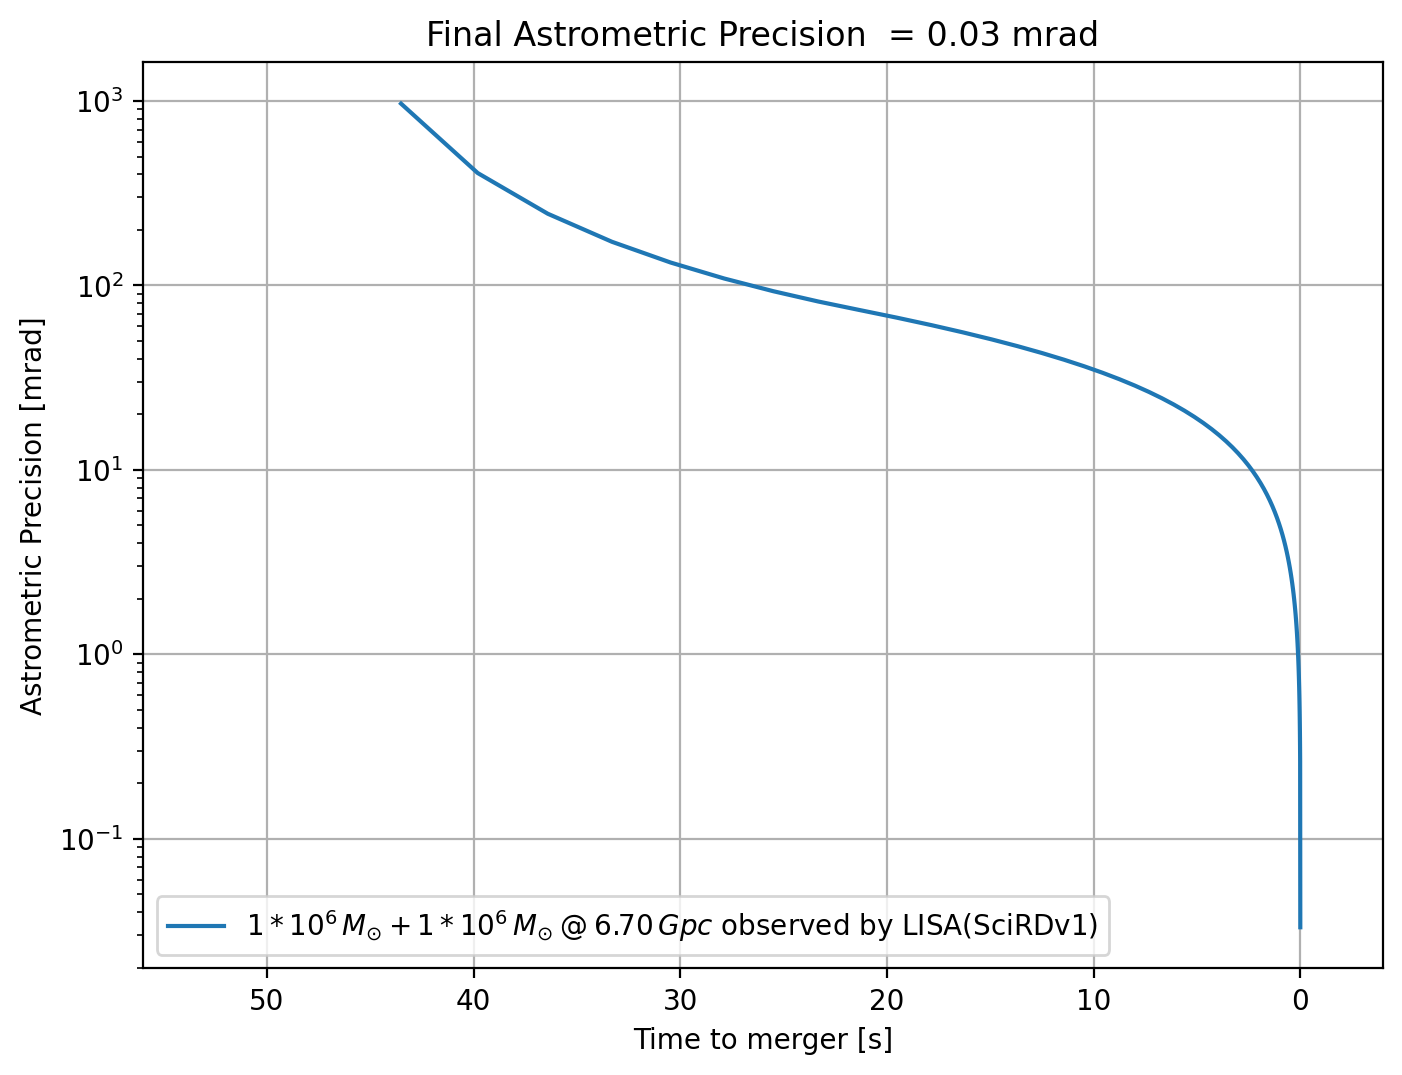

In [12]:
# Angular resolution
deltaTheta = deltaThetaDiff[1:]/snrplot[1:]
fig = plt.figure(figsize=[8,6],dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(-tplot[1:]*52/constants.year,deltaTheta*1e3,label='%s observed by %s' % (sigLabel, model.get('label')))
plt.xlim([-tstart*52/constants.year+4,-4])
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.xlabel('Time to merger [s]')
plt.ylabel('Astrometric Precision [mrad]')
plt.title('Final Astrometric Precision  = %2.1g mrad' % (deltaTheta[-1]*1e3))